In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import cv2
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

# Auxiliary functions

In [ ]:
def save_model(model, model_prefix=""):
    # Get a list of all files and directories in the current directory
    all_files = os.listdir()

    # Filter out directories that match the model prefix
    model_directories = [d for d in all_files if os.path.isdir(d) and d.startswith(model_prefix)]

    # If there are no existing models, start with version 1
    if not model_directories:
        new_version = 1
    else:
        # Extract version numbers from existing model directories
        existing_versions = [int(d[len(model_prefix):]) for d in model_directories]
        # Find the latest version
        latest_version = max(existing_versions)
        # Increment the latest version for the new model
        new_version = latest_version + 1

    # Construct the new model directory name
    new_model_name = f'{model_prefix}{new_version}'

    # Save the model
    model.save(new_model_name)

    # Delete the model from memory
    del model

    print(f'Saved model as {new_model_name}')

In [ ]:
def plot_confusion_matrix(model, X_test, y_test, labels=""):

    # Predict labels for the entire test set
    predictions = model.predict(preprocess_input(X_test), verbose=0)

    # Display the shape of the predictions
    print("Predictions Shape:", predictions.shape)
    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

    # Display the computed metrics
    print('Accuracy:', accuracy.round(4))
    print('Precision:', precision.round(4))
    print('Recall:', recall.round(4))
    print('F1:', f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=list(np.unique(labels)), yticklabels=list(np.unique(labels)), cmap='Oranges')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

    tp, fp, fn, tn = cm.ravel()
    print("True Positive {}".format(tp))
    print("False Positive {}".format(fp))
    print("False Negative {}".format(fn))
    print("True Negative {}".format(tn))


In [ ]:
def build_model(input_shape, dropout_rate = 0.1, seed=seed, img_size = 224):
    # Create an input layer with shape (input_shape)
    inputs = tfk.Input(shape = input_shape)

    x = tfkl.Resizing(img_size, img_size) (inputs)
    x = tfkl.Reshape((img_size,img_size,3)) (x)

    img_augmentation = tfk.Sequential([
        tfkl.RandomRotation(factor=0.15),
        tfkl.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tfkl.RandomFlip(),
        tfkl.RandomContrast(factor=0.1),
    ],name="img_augmentation")

    input_augmented = img_augmentation(x)

    # Implementing EfficientNetV2B2 from keras.applications
    efficientNet = tfk.applications.EfficientNetV2B2(
        input_shape = (img_size, img_size, 3),
        include_top = False,
        weights = "imagenet",
        pooling="avg"
    )

     # Use the supernet as feature extractor, i.e. freeze all its weigths
    efficientNet.trainable = False

    model_output = efficientNet(input_augmented)

    batch_norm = tfkl.BatchNormalization()(model_output)

    hidden_layer = tfkl.Dense(units = 256, kernel_initializer = tfk.initializers.HeUniform(seed = seed), name = 'HiddenDense1')(batch_norm)
    batch_norm = tfkl.BatchNormalization(name="BatchNorm1") (hidden_layer)
    hidden_activation = tfkl.Activation('relu', name = 'HiddenActivation1')(batch_norm)

    dropout_layer = tfkl.Dropout(dropout_rate, seed=seed)(hidden_activation)

    hidden_layer = tfkl.Dense(units = 256, kernel_initializer = tfk.initializers.GlorotUniform(seed = seed), name = 'HiddenDense2')(dropout_layer)
    batch_norm = tfkl.BatchNormalization(name="BatchNorm2") (hidden_layer)
    hidden_activation = tfkl.Activation('relu', name = 'HiddenActivation2')(batch_norm)

    dropout_layer = tfkl.Dropout(dropout_rate, seed=seed)(hidden_activation)

    hidden_layer = tfkl.Dense(units = 256, kernel_initializer = tfk.initializers.GlorotUniform(seed = seed), name = 'HiddenDense3')(dropout_layer)
    batch_norm = tfkl.BatchNormalization(name="BatchNorm3") (hidden_layer)
    hidden_activation = tfkl.Activation('relu', name = 'HiddenActivation3')(batch_norm)

    dropout_layer = tfkl.Dropout(dropout_rate, seed=seed)(hidden_activation)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs_layer = tfkl.Dense(2, activation = 'softmax')(dropout_layer)


    # Create a Model connecting input and output
    model = tfk.Model(inputs = inputs, outputs = outputs_layer, name = 'model')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss = tfk.losses.BinaryCrossentropy(), optimizer = tfk.optimizers.Adam(), metrics = ['accuracy'])

    return model

In [ ]:
def remove_outliers(data, labels, outlier_list=(58, 332)):

    for i in outlier_list:
        mask = ~np.all(data == data[i], axis = (1,2,3))
        data = data[mask]
        labels = labels[mask]

    return data, labels

In [ ]:
def remove_duplicates(X, y):

    unique_indices = np.unique(X, return_index=True, axis=0)[1]

    X = X[unique_indices]
    y = y[unique_indices]

    return np.array(X), np.array(y)

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return (gamma_1_sample / (gamma_1_sample + gamma_2_sample)).numpy()

In [ ]:
def mixup(x_train, labels_train, alpha=0.2):

    lam = np.random.beta(alpha, alpha)

    batch_size = x_train.shape[0]

    indices = np.random.permutation(batch_size)

    x_mix = lam * x_train + (1 - lam) * x_train[indices, :]
    labels_mix = lam * labels_train + (1 - lam) * labels_train[indices, :]

    return x_mix, labels_mix


# Data Import

In [ ]:
# Extracting data from public_data.npz
file = np.load('public_data.npz', allow_pickle=True)

# Creating the two numpy arrays
data = file['data']
labels = file['labels']

data,labels = remove_outliers(data, labels)
data, labels = remove_duplicates(data, labels)

print(pd.DataFrame(labels, columns=['class'])['class'].value_counts())

# Bring labels to categoricals and 1-hot encoding
y = np.where(labels == 'healthy', 0, 1)
y = tfk.utils.to_categorical(y, num_classes=len(np.unique(y)))

# Split train_validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data,
    y,
    random_state=seed,
    test_size=.1,
    stratify=y)

# Split train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test), # Ensure validation set size matches test set size
    random_state=seed,
    stratify=y_train_val
)

y_train_num = [row[0] for row in y_train]  # Extract info from first cell of each element

# Create DataFrame and count values
count_num_cl = pd.Series(y_train_num).value_counts()

print("Number of positives and negatives: ")
print(count_num_cl)

# Image Augmentation

In [ ]:
new_data, new_label = mixup(X_train, y_train)

In [ ]:
X_train = np.concatenate((X_train, new_data), axis = 0)
y_train = np.concatenate((y_train, new_label), axis = 0)

In [ ]:
del new_data
del new_label

In [ ]:
# Display the count of occurrences of label classes in the dataset
print('Counting occurrences of label classes:')
print(pd.DataFrame(np.argmax(y_train, axis=1), columns=['class'])['class'].value_counts())

Counting occurrences of label classes:
0    4912
1    2888
Name: class, dtype: int64


In [ ]:
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (7800, 96, 96, 3), y_train shape: (7800, 2)
X_val shape: (501, 96, 96, 3), y_val shape: (501, 2)
X_test shape: (501, 96, 96, 3), y_test shape: (501, 2)


In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 512 # TODO try different batch_size
epochs = 1000

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}\nOutput Shape: {output_shape}\nBatch Size: {batch_size}\nEpochs: {epochs}")

Input Shape: (96, 96, 3)
Output Shape: (2,)
Batch Size: 512
Epochs: 1000


# Callbacks

In [ ]:
lr_patience = 5

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor = 'val_accuracy',     # Metric to monitor
    patience = lr_patience,       # Number of epochs with no improvement after which learning rate will be reduced
    factor = 0.9,                 # Factor by which the learning rate will be reduced  TODO try different factors
    mode = 'auto',                # Mode to decide when to reduce learning rate
    min_lr = 1e-5                 # Minimum learning rate
)

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 25,
    restore_best_weights = True,
    mode = 'auto')

In [ ]:
callbacks = [early_stopping, lr_scheduler]

# Build Model

In [ ]:
model = build_model(input_shape=input_shape,
                    dropout_rate=0.2,
                    seed=seed)

model.summary()

35839040/35839040 [==============================] - 0s 0us/step


## Train the model

In [ ]:
# determine distribution of the two classes
# Remember: class 0 is healty and class 1 is unhealty
num_healty = sum(sublist[0] for sublist in y_train)
num_unhealty = sum(sublist[1] for sublist in y_train)

if num_healty > num_unhealty:
  class_weights = {
      0: 1,  # Class 0
      1: (num_healty / float(num_unhealty))  # Class 1, assuming class 1 is the minority and you want to weight it higher
  }
else:
  class_weights = {
      0: (num_unhealty / float(num_healty)),  # Class 0, assuming class 0 is the minority and you want to weight it higher
      1: 1  # Class 1
  }

history = model.fit(
    x = preprocess_input(X_train), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = callbacks,
    class_weight=class_weights
).history

Epoch 1/1000
16/16 [==============================] - 84s 3s/step - loss: 0.7863 - accuracy: 0.6728 - val_loss: 0.5749 - val_accuracy: 0.7745 - lr: 0.0010
Epoch 2/1000
16/16 [==============================] - 17s 1s/step - loss: 0.5924 - accuracy: 0.7824 - val_loss: 0.5003 - val_accuracy: 0.7984 - lr: 0.0010
Epoch 3/1000
16/16 [==============================] - 17s 1s/step - loss: 0.5425 - accuracy: 0.8129 - val_loss: 0.4878 - val_accuracy: 0.8024 - lr: 0.0010
Epoch 4/1000
16/16 [==============================] - 18s 1s/step - loss: 0.5175 - accuracy: 0.8238 - val_loss: 0.4483 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 5/1000
16/16 [==============================] - 18s 1s/step - loss: 0.4809 - accuracy: 0.8337 - val_loss: 0.4236 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 6/1000
16/16 [==============================] - 18s 1s/step - loss: 0.4832 - accuracy: 0.8399 - val_loss: 0.4167 - val_accuracy: 0.8164 - lr: 0.0010
Epoch 7/1000
16/16 [==============================] - 18s 1s/step - lo

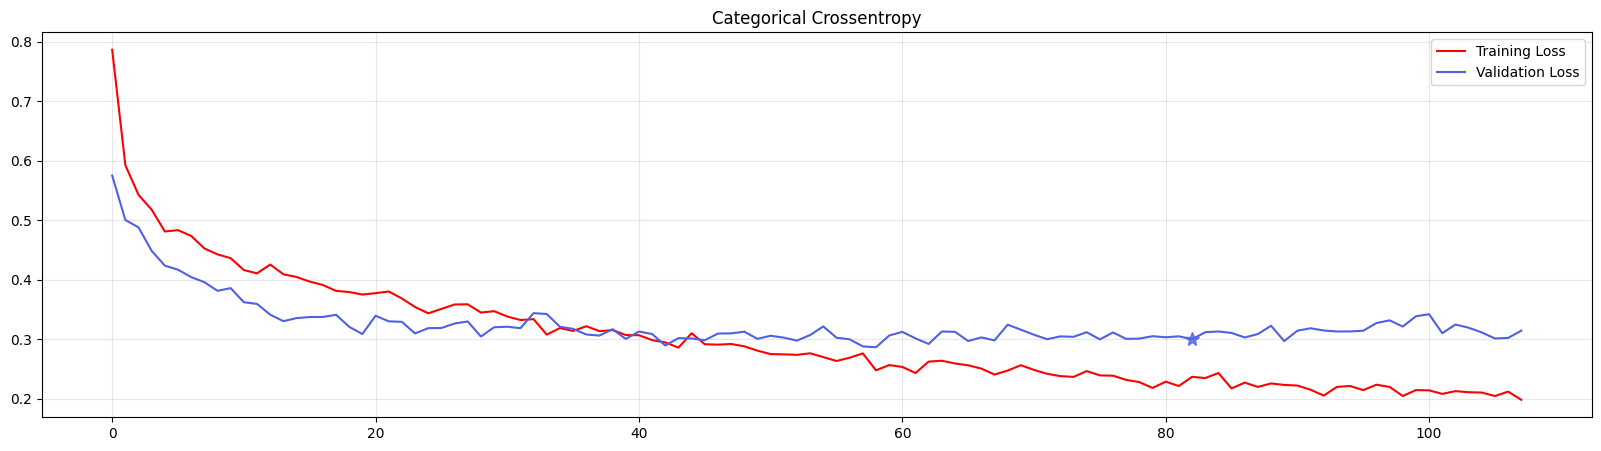

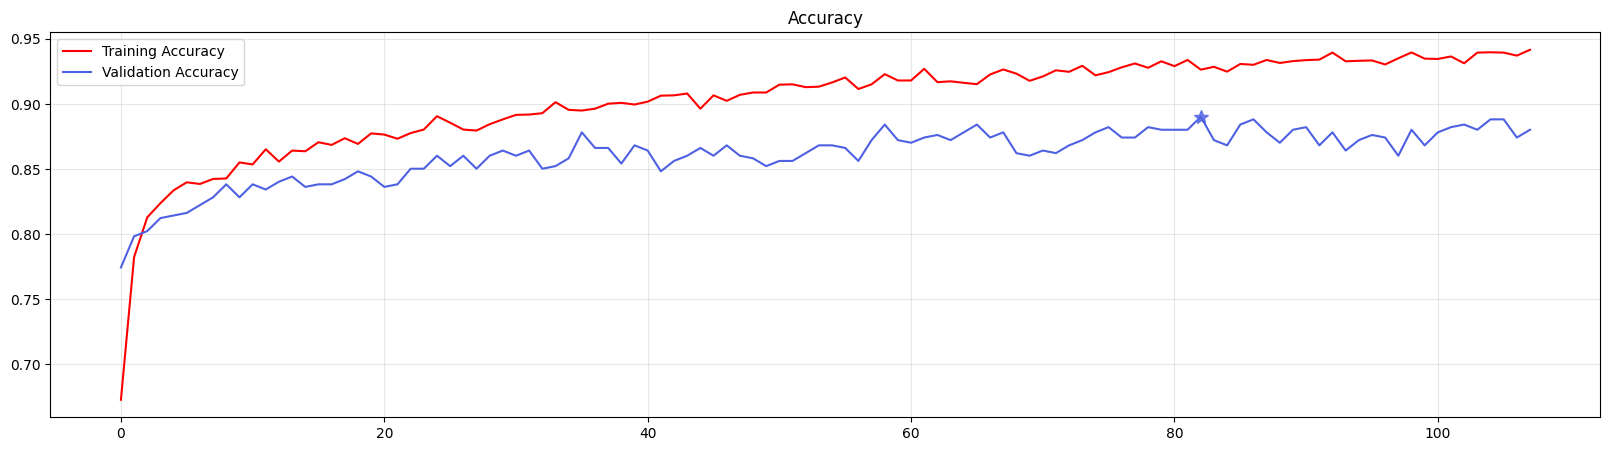

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])

# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(20,5))
plt.plot(history['loss'], color='#FF0000', label='Training Loss')
plt.plot(history['val_loss'], color='#4D61E2', label='Validation Loss')
plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper right')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], color='#FF0000', label='Training Accuracy')
plt.plot(history['val_accuracy'], color='#4D61E2', label='Validation Accuracy')
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save("./Checkpoint")

# Fine tuning

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 reshape (Reshape)           (None, 224, 224, 3)       0         
                                                                 
 img_augmentation (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
 batch_normalization (Batch  (None, 1408)              5632  

In [ ]:
for i, layer in enumerate(model.get_layer('efficientnetv2-b2').layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False
37 bl

In [ ]:
# Set all MobileNetV2 layers as trainable
model.get_layer('efficientnetv2-b2').trainable = True
for i, layer in enumerate(model.get_layer('efficientnetv2-b2').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
end_freeze = 198

for i, layer in enumerate(model.get_layer('efficientnetv2-b2').layers[:end_freeze]):
  layer.trainable=False

for i, layer in enumerate(model.get_layer('efficientnetv2-b2').layers):
   if isinstance(layer, tfkl.BatchNormalization):
     layer.trainable = False
   print(i, layer.name, layer.trainable)
model.summary()

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

In [ ]:
save_model(model, 'Fine_tuning_checkpoint')

In [ ]:
plot_confusion_matrix(model=model, X_test=X_test, y_test=y_test, labels=("Healthy", "Unhealthy"))